In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from PIL import Image
import numpy as np
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# Generate data paths with labels
data_dir = '/content/drive/MyDrive/Gurumukhi Nerual Network/train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)


In [ ]:
df


,filepaths,labels
0,/content/drive/MyDrive/Gurumukhi Nerual Networ...,9
1,/content/drive/MyDrive/Gurumukhi Nerual Networ...,9
2,/content/drive/MyDrive/Gurumukhi Nerual Networ...,9
3,/content/drive/MyDrive/Gurumukhi Nerual Networ...,9
4,/content/drive/MyDrive/Gurumukhi Nerual Networ...,9
...,...,...
995,/content/drive/MyDrive/Gurumukhi Nerual Networ...,2
996,/content/drive/MyDrive/Gurumukhi Nerual Networ...,2
997,/content/drive/MyDrive/Gurumukhi Nerual Networ...,2
998,/content/drive/MyDrive/Gurumukhi Nerual Networ...,2


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 800 validated image filenames belonging to 10 classes.
Found 120 validated image filenames belonging to 10 classes.
Found 80 validated image filenames belonging to 10 classes.


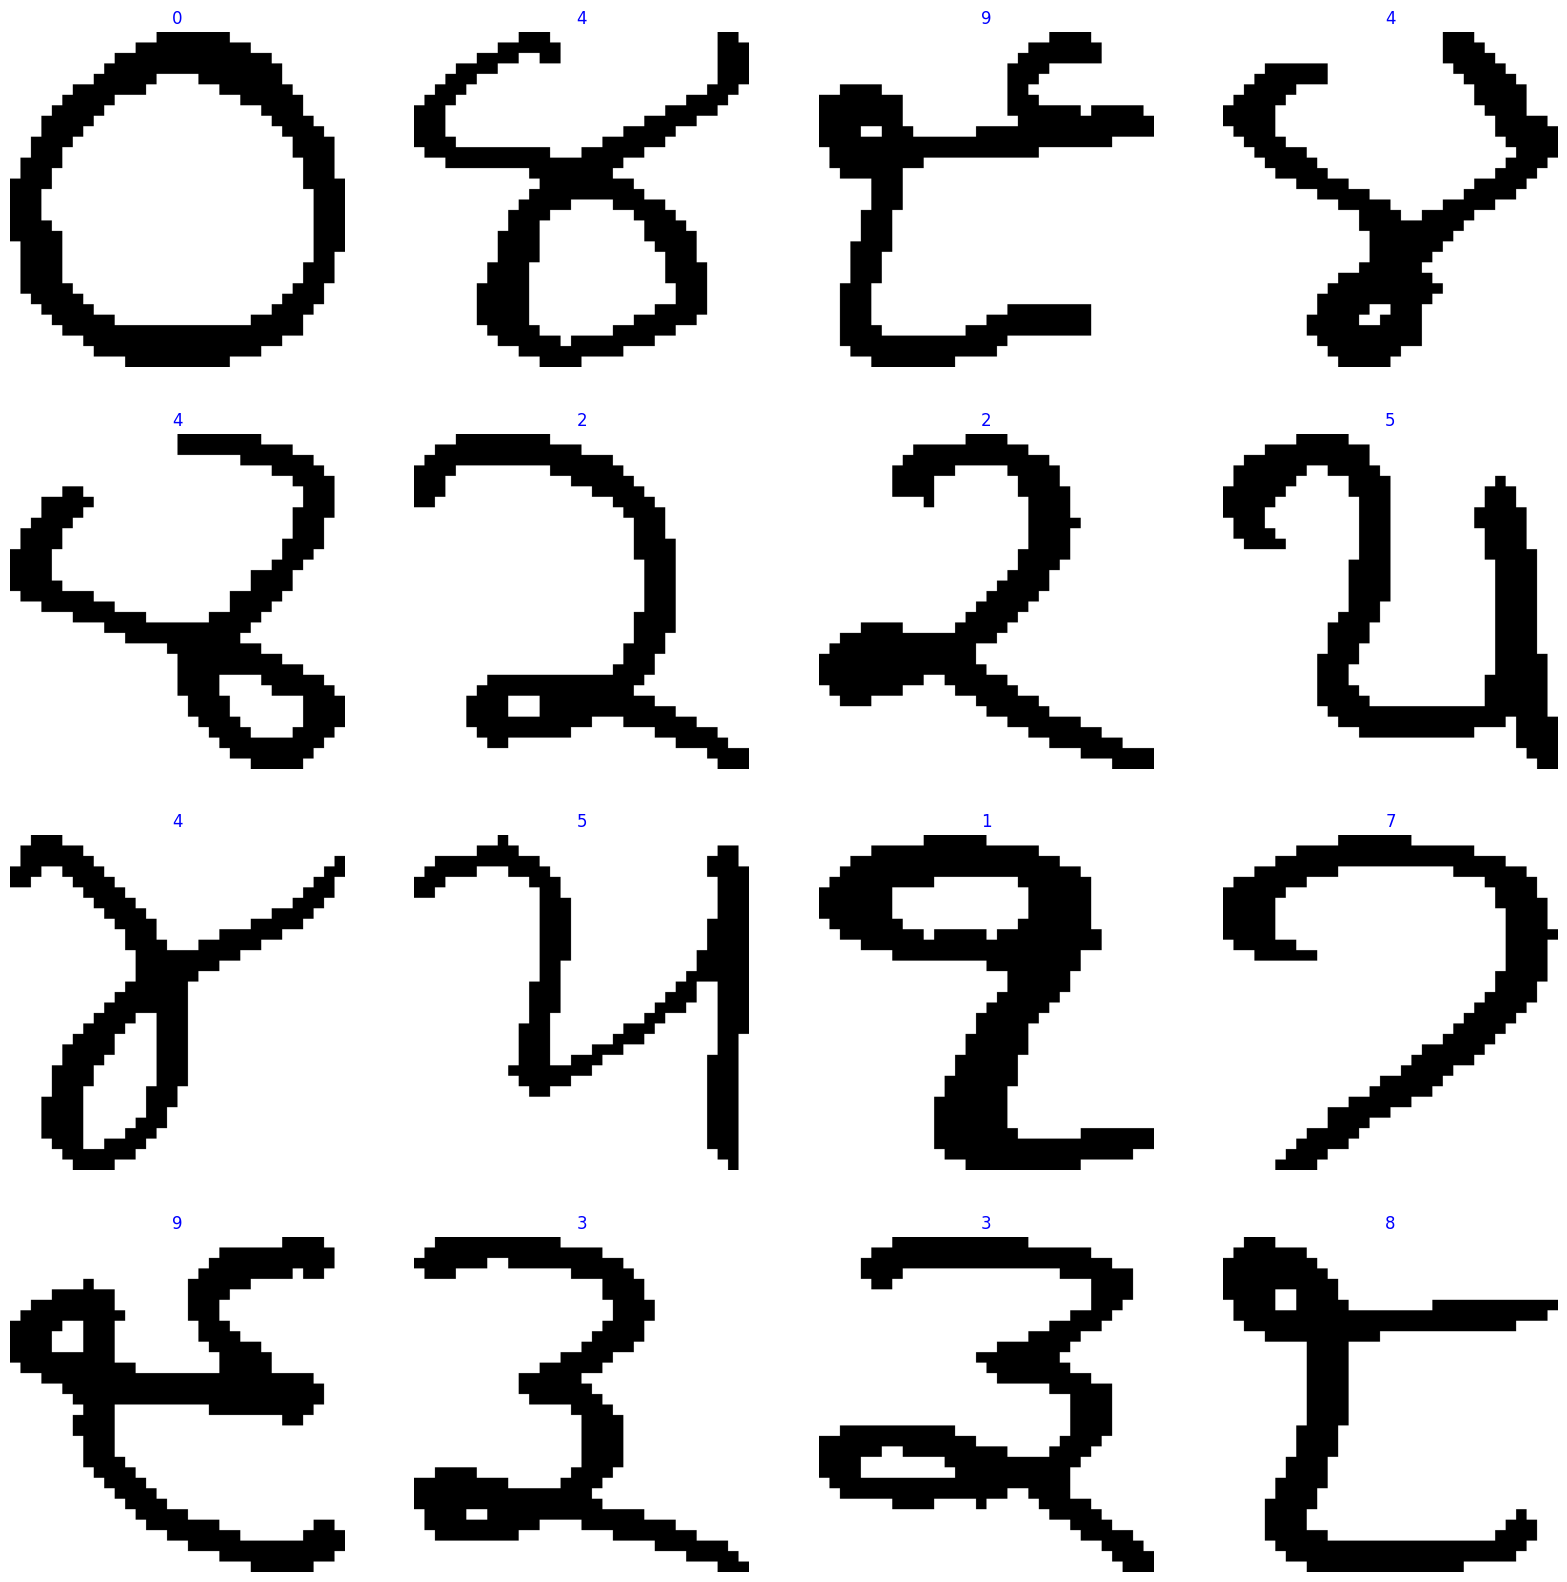

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Flatten(input_shape=img_shape),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_18 (Dense)            (None, 64)                9633856   
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 10)                330       
                                                                 
Total params: 9,636,266
Trainable params: 9,636,266
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 16   # set batch size for training
epochs = 100   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/100
50/50 [==============================] - 12s 217ms/step - loss: 2.1945 - accuracy: 0.1475 - val_loss: 2.1877 - val_accuracy: 0.1500
Epoch 2/100
50/50 [==============================] - 12s 237ms/step - loss: 2.1938 - accuracy: 0.1475 - val_loss: 2.1875 - val_accuracy: 0.1500
Epoch 3/100
50/50 [==============================] - 11s 218ms/step - loss: 2.1932 - accuracy: 0.1475 - val_loss: 2.1876 - val_accuracy: 0.1500
Epoch 4/100
50/50 [==============================] - 10s 191ms/step - loss: 2.1926 - accuracy: 0.1475 - val_loss: 2.1877 - val_accuracy: 0.1500
Epoch 5/100
50/50 [==============================] - 11s 221ms/step - loss: 2.1920 - accuracy: 0.1475 - val_loss: 2.1874 - val_accuracy: 0.1500
Epoch 6/100
50/50 [==============================] - 10s 197ms/step - loss: 2.1915 - accuracy: 0.1412 - val_loss: 2.1876 - val_accuracy: 0.1500
Epoch 7/100
50/50 [==============================] - 9s 176ms/step - loss: 2.1911 - accuracy: 0.1437 - val_loss: 2.1876 - val_accuracy: 

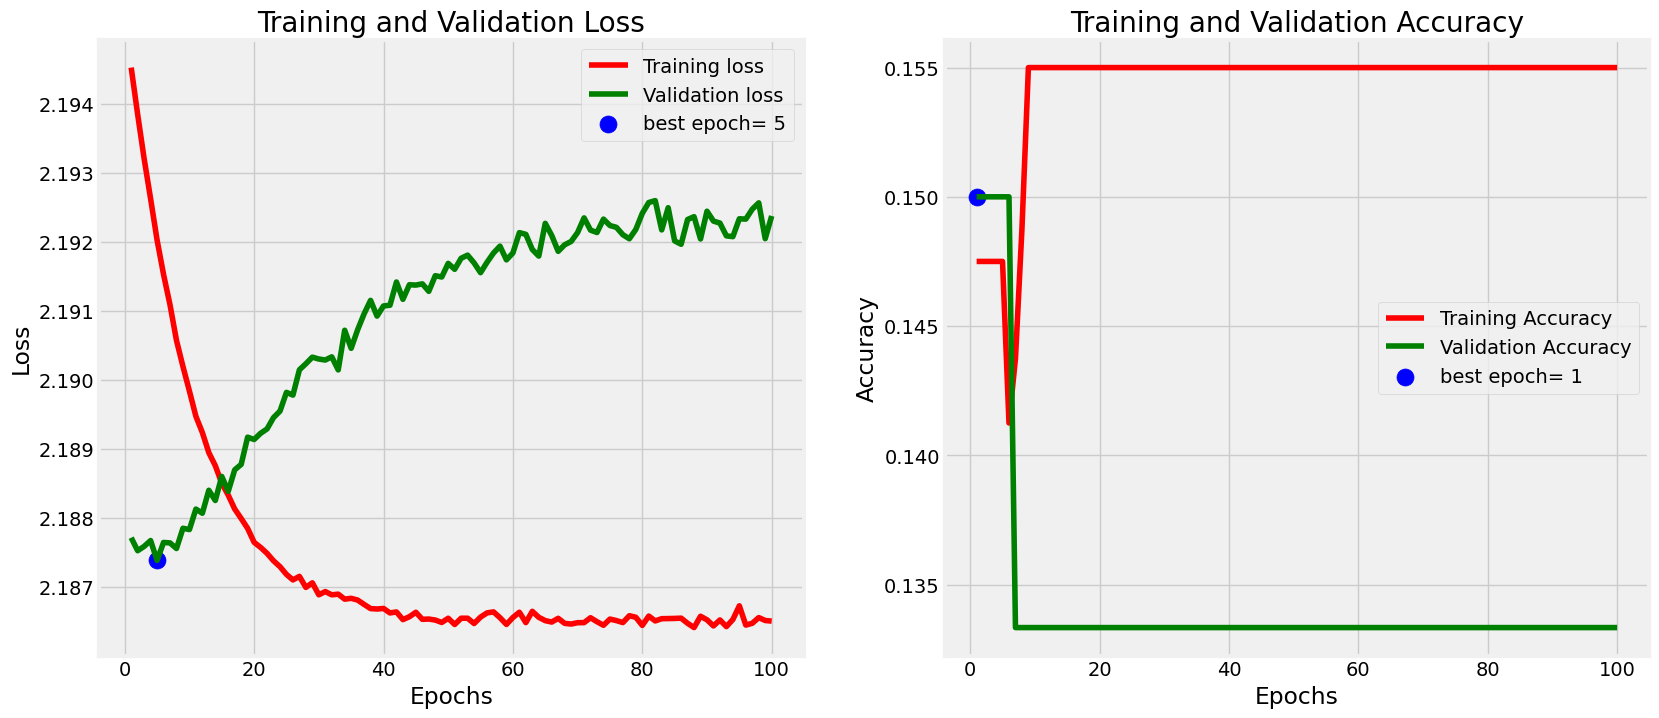

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 0s 302ms/step - loss: 2.2188 - accuracy: 0.0625
Train Loss:  2.293999195098877
Train Accuracy:  0.1875
--------------------
Validation Loss:  2.3014566898345947
Validation Accuracy:  0.0
--------------------
Test Loss:  2.2188212871551514
Test Accuracy:  0.0625


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

<ipython-input-51-01135dd8c8ed>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


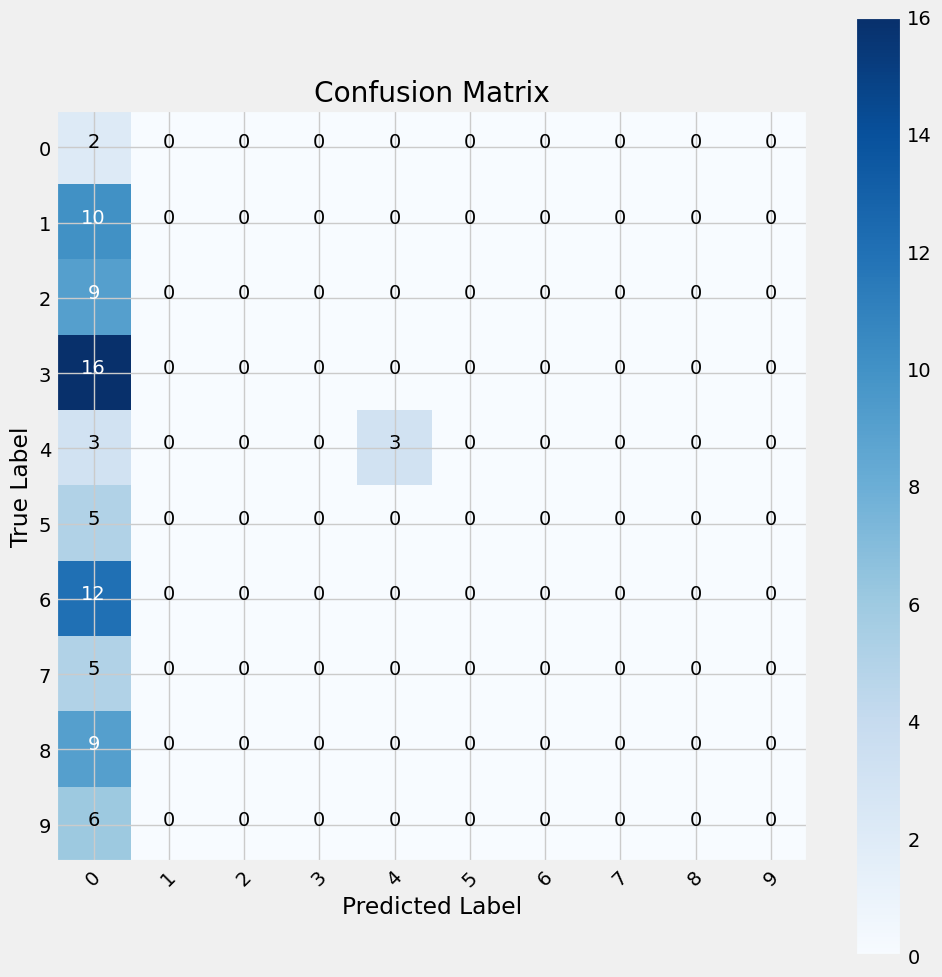

In [ ]:
import itertools
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

           0       0.03      1.00      0.05         2
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        16
           4       1.00      0.50      0.67         6
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         6

    accuracy                           0.06        80
   macro avg       0.10      0.15      0.07        80
weighted avg       0.08      0.06      0.05        80



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


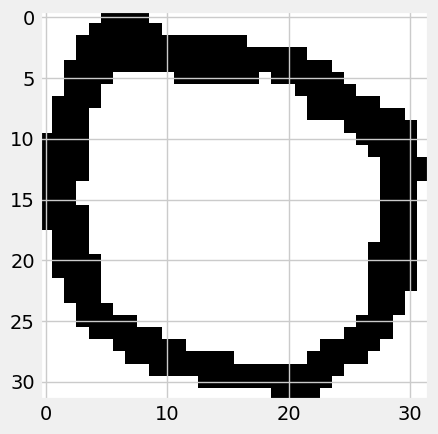

In [ ]:
img = tf.keras.utils.load_img('/content/drive/MyDrive/Gurumukhi Nerual Network/val/0/1.tiff')
plt.imshow(img)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
TEST_DIR = '/content/drive/MyDrive/Gurumukhi Nerual Network/val'
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TEST_DIR,
  seed=123,
  image_size=(150, 150),
  batch_size=64,
  label_mode = 'categorical')

Found 20 files belonging to 10 classes.


In [ ]:
class_names = val_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
img = Image.open('/content/drive/MyDrive/Gurumukhi Nerual Network/val/0/1.tiff')
img = img.convert('RGB') # convert to RGB format
img = img.resize(img_size)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.3f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 43ms/step
This image most likely belongs to 0 with a 10.153 percent confidence.
